In [2]:
from PIL import Image, ImageFont, ImageDraw
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import json
from random import shuffle
import random
from rembg import remove
from transformers import OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor
import itertools
import seaborn as sns
import brambox as bb
from typing import List, Tuple, Union, Optional, Dict
import time
import warnings
import ipyparallel as ipp

PyGEOS is not installed and thus segmentation related functionality will not work


In [3]:
# settings
annotations_folder_path: str = "../../../Data/Annotations/"
images_folder_path: str = "../../../Data/JPEGImages/"
fixed_images_path: str = "../../../Data/Fixed_support/"

examples_path: str = "../../../Tex/fig/chapter3/shell_examples/"

# Defining some classes and values

In [4]:
class BBAnnotatedImage:
    def __init__(self, *, img_dir = "", filename= "", annotations:pd.DataFrame) -> None:
        if not filename:
            raise ValueError("filename cannot be empty")
        if not os.path.exists(os.path.join(img_dir, filename)):
            raise FileNotFoundError(f"image file {filename} not found in {img_dir}")
        self.filename: str = filename
        self.image: Image.Image = Image.open(os.path.join(img_dir, filename))
        self.annotations: pd.DataFrame = annotations
    
    @property
    def width(self) -> int:
        return self.image.width
    
    @property
    def height(self) -> int:
        return self.image.height
    
    @staticmethod
    def from_xml(xml_file:str, img_dir:str = "") -> 'BBAnnotatedImage':
        annotations:pd.DataFrame = bb.io.load('anno_pascalvoc', xml_file)
        filename = annotations.iloc[[0]]['image'].values[0] + '.jpg'
        return BBAnnotatedImage(filename = filename, img_dir = img_dir, annotations = annotations)
    
    def get_object_image_cutout(self, annotation_row:pd.Series) -> Image.Image:
        return self.image.crop((annotation_row['x_top_left'], annotation_row['y_top_left'], annotation_row['x_top_left'] + annotation_row['width'], annotation_row['y_top_left'] + annotation_row['height']))
    
    @property
    def annotation_classes(self) -> list[str]:
        return self.annotations['class_label'].tolist()
    
    @property
    def object_image_cutouts(self) -> list[Image.Image]:
        return [self.get_object_image_cutout(annotation) for _, annotation in self.annotations.iterrows()]
    
    @property
    def objects(self) -> list[tuple[str, Image.Image]]:
        return list(zip(self.annotation_classes, self.object_image_cutouts))

 
USE_TEXT = 0
USE_RANDOM_IMAGE = 1
USE_PICKED_IMAGE = 2

# loading the dataset

In [33]:
dir, dirs, files = next(os.walk(annotations_folder_path))

annotated_images:list[BBAnnotatedImage] = []

for file in files:
    annotated_images.append(BBAnnotatedImage.from_xml(annotations_folder_path + file, images_folder_path))

# add area column
for annotated_image in annotated_images:
    for _, annotation in annotated_image.annotations.iterrows():
        annotated_image.annotations.loc[_, 'area'] = annotation['width'] * annotation['height']

all_annotations = pd.concat([annotated_image.annotations for annotated_image in annotated_images])

print(all_annotations.head())

# get list of all area values
area_values = []
for _, annotation in all_annotations.iterrows():
    area_values.append(annotation['area'])


print(max(area_values), min(area_values))
mean_area = np.mean(area_values)
std_area = np.std(area_values)
threshold_z_score = 2

areas_outlier_removed = []
for area in area_values:
    if abs(area - mean_area) < threshold_z_score * std_area:
        areas_outlier_removed.append(area)
print(max(areas_outlier_removed), min(areas_outlier_removed))

area_filter_treshold = max(areas_outlier_removed)

               image         class_label  id  x_top_left  y_top_left  width  \
0  IMG20230217102744       Baltic tellin NaN      2708.0      2272.0  300.0   
1  IMG20230217102744              Cockle NaN      3825.0      2803.0  295.0   
2  IMG20230217102744  Thick trough shell NaN      5850.0      4447.0  182.0   
0  IMG20230217102746       Baltic tellin NaN      2375.0      1783.0  445.0   
1  IMG20230217102746              Cockle NaN      4056.0      2530.0  445.0   

   height  occluded  truncated   lost  difficult  ignore      area  
0   258.0       0.0        0.0  False      False   False   77400.0  
1   253.0       0.0        0.0  False      False   False   74635.0  
2   172.0       0.0        0.0  False      False   False   31304.0  
0   392.0       0.0        0.0  False      False   False  174440.0  
1   397.0       0.0        0.0  False      False   False  176665.0  
5023460.0 27872.0
983740.0 27872.0


## Dataset statistics

annotations: {
    "Baltic tellin": 69,
    "Cockle": 89,
    "Thick trough shell": 91,
    "Mussel": 268,
    "Banded wedge shell": 32,
    "Elliptical trough shell": 18,
    "Cut trough shell": 36,
    "Oyster": 9,
    "Jackknife": 2
}
Total images: 96
Total annotations: 614
Total images: 302
Total un-annotated images: 206
[27872.0, 30444.0, 31304.0, 34320.0, 35175.0, 35905.0, 38804.0, 39130.0, 39501.0, 39775.0, 40600.0, 41925.0, 43240.0, 43780.0, 45024.0, 45264.0, 45901.0, 46315.0, 46795.0, 50232.0, 54516.0, 55000.0, 56430.0, 56964.0, 57566.0, 59598.0, 60753.0, 62244.0, 63832.0, 63948.0, 64965.0, 66389.0, 67797.0, 67800.0, 67854.0, 68272.0, 69560.0, 69936.0, 70272.0, 71441.0, 72452.0, 72772.0, 74635.0, 74740.0, 75472.0, 77400.0, 77720.0, 77843.0, 77910.0, 78030.0, 78108.0, 78616.0, 78765.0, 78948.0, 79460.0, 79534.0, 80073.0, 80586.0, 82650.0, 82663.0, 84280.0, 84364.0, 86460.0, 86584.0, 87579.0, 87750.0, 87912.0, 89040.0, 89376.0, 93532.0, 94428.0, 94752.0, 95718.0, 96280.0, 96570.

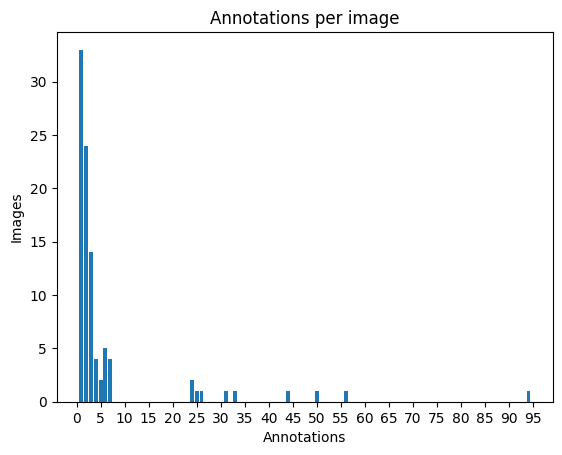

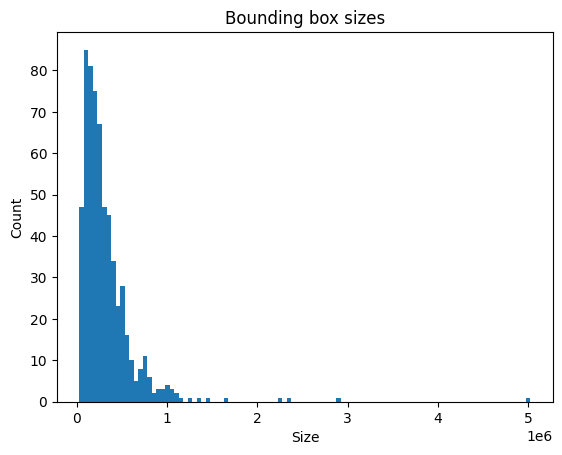

In [6]:
classes_count: dict[str, int] = {}

for _, annotation in all_annotations.iterrows():
    if annotation['class_label'] in classes_count:
        classes_count[annotation['class_label']] += 1
    else:
        classes_count[annotation['class_label']] = 1

print("annotations:", json.dumps(classes_count, indent=4))

print(f"Total images: {len(annotated_images)}")
print(f"Total annotations: {sum(classes_count.values())}")

# find the total un-anotated images
dir, dirs, files = next(os.walk(images_folder_path))
print(f"Total images: {len(files)}")
print(f"Total un-annotated images: {len(files) - len(annotated_images)}")

annotations_per_image_count = {}
for img in annotated_images:
    if len(img.annotations) in annotations_per_image_count:
        annotations_per_image_count[len(img.annotations)] += 1
    else:
        annotations_per_image_count[len(img.annotations)] = 1
# sort the dictionary by key
annotations_per_image_count = dict(sorted(annotations_per_image_count.items()))

# draw a graph of the annotations per image with as title "Annotations per image"
plt.bar(annotations_per_image_count.keys(), annotations_per_image_count.values())
plt.title("Annotations per image")
#more lines on the x-axis
plt.xticks(np.arange(0, max(annotations_per_image_count.keys()) + 5, 5.0))
plt.xlabel("Annotations")
plt.ylabel("Images")

# draw a bell curve of the size of the bounding boxes
# first get the sizes of the bounding boxes
sizes = []
for img in annotated_images:
    for _, annotation in img.annotations.iterrows():
        sizes.append(annotation['width'] * annotation['height'])
        
# sort the sizes
sizes.sort()
print(sizes)
# average and median size
print(f"Average size: {sum(sizes) / len(sizes)}")
print(f"Average compared to total image size: {((sum(sizes) / len(sizes)) / (img.width * img.height))*100}%")
print(f"Median size: {sizes[len(sizes) // 2]}")
plt.figure()
plt.hist(sizes, bins=100)
plt.title("Bounding box sizes")
plt.xlabel("Size")
plt.ylabel("Count")


# write 9 examples of images with annotations to a file (1.jpg => 9.jpg)
img_indexes = [1,5,20,54,92,52,15,65,75]
for i in range(9):
    annotated_image = annotated_images[img_indexes[i]]
    img = annotated_image.image.copy()
    draw = ImageDraw.Draw(img)
    for _, annotation in annotated_image.annotations.iterrows():
        draw.rectangle(((annotation['x_top_left'], annotation['y_top_left']), (annotation['x_top_left'] + annotation['width'], annotation['y_top_left'] + annotation['height'])), outline="red", width=20)
        draw.text((annotation['x_top_left'], annotation['y_top_left']), annotation['class_label'], fill="red", font=ImageFont.truetype("arial.ttf", 150))
    draw.text((10, 10), annotated_image.filename, fill="red", font=ImageFont.truetype("arial.ttf", 150))
    # resize the image by 10 times
    img = img.resize((int(img.width / 10), int(img.height / 10)))
    img.save(examples_path + str(i + 1) + ".jpg")

## Preparing the model

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
processor:OwlViTProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

Using GPU


## Data loading

In [51]:
# mode = USE_TEXT
mode = USE_RANDOM_IMAGE
# mode = USE_PICKED_IMAGE

remove_bg = False

#clone all img into test list
test_images = annotated_images.copy()

if mode == USE_TEXT:
    raise NotImplementedError("I should implement this")

elif mode == USE_RANDOM_IMAGE:
    # find an image for each class and extract it
    support_images = set()
    support_images_cutouts = {}
    for class_name in classes_count:
        for img in annotated_images:
            for _, annotation in img.annotations.iterrows():
                if annotation['class_label'] == class_name:
                    support_images.add(img)
                    support_images_cutouts[class_name] = img.image.crop((annotation['x_top_left'], annotation['y_top_left'], annotation['x_top_left'] + annotation['width'], annotation['y_top_left'] + annotation['height']))
                    break
            if class_name in support_images_cutouts:
                break

    for img in support_images:
        test_images.remove(img)

elif mode == USE_PICKED_IMAGE:
    support_images_cutouts = {}
    imgs = list(os.walk(fixed_images_path + "base"))[0][2]
    for img in imgs:
        print(f"loading {img}")
        shell_name = img.split(".")[0]
        image = Image.open(fixed_images_path + "base/" + img)
        support_images_cutouts[shell_name] = image

else:
    raise NotImplementedError("Mode not set")

test_image_annotations = pd.concat([img.annotations for img in test_images])

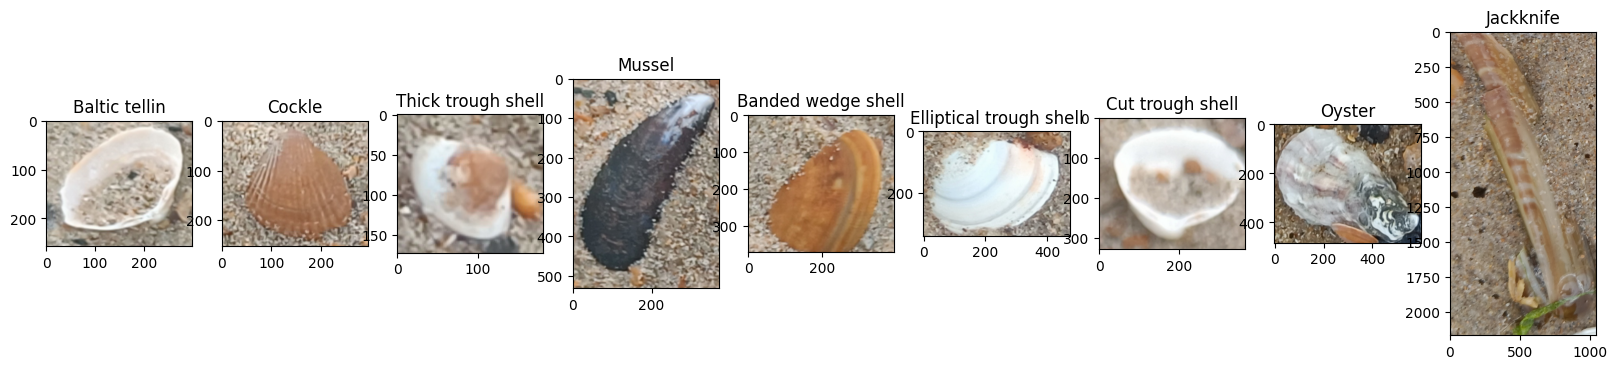

In [9]:
if remove_bg and (mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE):
    # loop over all support images and remove background
    for class_name, img in support_images_cutouts.items():
        print(f"removing background from {class_name}")
        img_copy = img.copy()
        img_copy = remove(img_copy, bgcolor=(0, 0, 0, 0)).convert("RGB")
        support_images_cutouts[class_name] = img_copy
        
if mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE:
    # show original images
    plt.figure(figsize=(20, 20))
    for i, (class_name, img) in enumerate(support_images_cutouts.items()):
        plt.subplot(1, len(support_images_cutouts), i + 1)
        plt.title(class_name)
        plt.imshow(img)
    if remove_bg:
        # show cutout images
        plt.figure(figsize=(20, 20))
        for i, (class_name, img) in enumerate(support_images_cutouts.items()):
            plt.subplot(1, len(support_images_cutouts), i + 1)
            plt.title(class_name)
            plt.imshow(img)
    

In [10]:
model = model.to(device)
model.eval()

outputs_list = []


vals = list(support_images_cutouts.values())

for q in range(len(test_images)):
    print(f"Query image {q}")

    test_image_annotated = test_images[q]

    test_image = test_image_annotated.image

    test_image_filename = test_image_annotated.filename

    inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")
    
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
    outputs.pred_boxes = outputs.target_pred_boxes.cpu()
    outputs_list.append(outputs)
    
# remove the model to free up memory
torch.cuda.empty_cache()


Query image 0
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 1
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 2
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 3
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 4
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 5
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 6
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 7
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 8
query_pixel_values: torch.Size([9, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])
Query image 9
query_pixel_values: torch.Size([

In [106]:
# process and save the results for each query image for a set of score_thresholds with results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
score_thresholds: list[float] = [0.00]

filter_too_big_options: list[bool] = [True, False]
iou_thresholds: list[float] = [i / 5 for i in range(1, 6)]

# make matrix of all options, with iou_thresholds set to 0 if do_nmss is False 
options = list(itertools.product(filter_too_big_options, iou_thresholds))

In [ ]:
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

detections:pd.DataFrame = pd.DataFrame(columns=['image', 'class_label', 'id', 'x_top_left', 'y_top_left', 'width', 'height', 'confidence', 'score_threshold', 'do_filtering', 'iou_threshold'])

detections['do_filtering'] = detections['do_filtering'].astype(bool)

for q in range(len(test_images)):
    image_results:pd.DataFrame = pd.DataFrame(columns=detections.columns)
    test_image_annotated = test_images[q]
    test_image_name = test_image_annotated.filename.split(".")[0]
    test_image = test_image_annotated.image
    target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))

    for score_threshold in score_thresholds:
        threshold_results:pd.DataFrame = pd.DataFrame(columns=detections.columns)
        print(f"Query image {q}, score_threshold {score_threshold}")
        results = processor.post_process_object_detection(outputs=outputs_list[q], target_sizes=target_sizes, threshold=score_threshold)

        boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
        for i in range(1, len(support_images_cutouts.keys())):
            im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
            boxes = torch.cat((boxes, im_boxes), dim=0)
            scores = torch.cat((scores, im_scores), dim=0)
            # add offset i to labels
            im_labels = im_labels + i
            labels = torch.cat((labels, im_labels), dim=0)

        boxes_orig = boxes
        scores_orig = scores
        labels_orig = labels

        for do_filtering, iou_threshold in options:
            print(f"Query image {q}, score_threshold {score_threshold}, do_filtering {do_filtering}, iou_threshold {iou_threshold}:", end="")
            boxes = boxes_orig[:]
            scores = scores_orig[:]
            labels = labels_orig[:]

            if do_filtering:
                # filter out too big boxes with area_filter_treshold
                indices = []
                for i in range(len(boxes)):
                    box = boxes[i]
                    x_top_left, y_top_left, width, height = box
                    if width * height > 1.5 * area_filter_treshold:
                        continue
                    else:
                        indices.append(i)

                boxes = boxes[indices]
                scores = scores[indices]
                labels = labels[indices]

            indices = torchvision.ops.nms(boxes, scores, iou_threshold)
            boxes = boxes[indices]
            scores = scores[indices]
            labels = labels[indices]

            print(f" {len(boxes)} detections")
            for i in range(len(boxes)):
                box = boxes[i]
                score = scores[i]
                label = labels[i]
                class_label = list(support_images_cutouts.keys())[label]
                x_top_left, y_top_left, width, height = box
                x_top_left, y_top_left, width, height, score = x_top_left.item(), y_top_left.item(), width.item(), height.item(), score.item()
                new_row:pd.DataFrame = pd.DataFrame(columns=detections.columns, data=[[test_image_name, class_label, i, x_top_left, y_top_left, width, height, score, score_threshold, do_filtering, iou_threshold]])
                threshold_results = pd.concat([threshold_results, new_row], ignore_index=True)

        image_results = pd.concat([image_results, threshold_results], ignore_index=True)
    detections = pd.concat([detections, image_results], ignore_index=True)

print(detections)
# add area column


In [132]:
bb.io.save(detections, "pandas",f"detections.pkl")

In [191]:
detections:pd.DataFrame = bb.io.load("pandas", "detections.pkl")
detections['area'] = detections['width'] * detections['height']
print(len(detections))

def get_detections_for_params(detections, *, do_filtering = None, area_filter_treshold_modifier=1000, iou_threshold = None, score_threshold = None):
    if do_filtering:
        # filter area smaller than area_filter_treshold
        detections = detections[detections['area'] < area_filter_treshold_modifier * area_filter_treshold]
        # detections = detections[detections['do_filtering'] == do_filtering]
    if iou_threshold is not None:
        detections = detections[detections['iou_threshold'] == iou_threshold]
    if score_threshold is not None:
        detections = detections[detections['confidence'] > score_threshold]
    return detections


670464


42854 False
98556 False
176272 False
286727 False
443768 False
641022 False
670464 False
670464 False
670464 False
670464 False


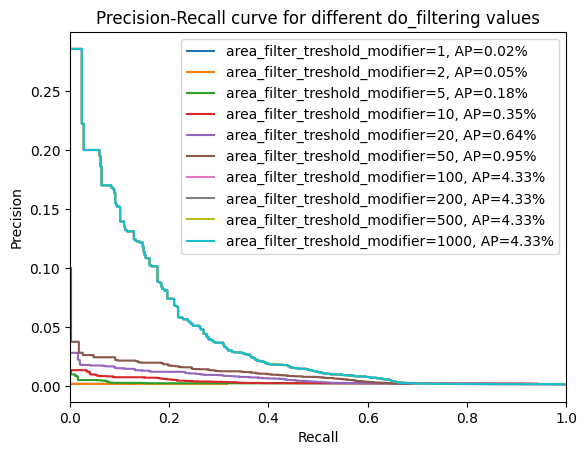

In [195]:

area_filter_threshold_modifiers = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

fig, ax = plt.subplots()

for area_filter_treshold_mod in area_filter_threshold_modifiers:
    test = get_detections_for_params(detections, do_filtering=True, area_filter_treshold_modifier=area_filter_treshold_mod)
    print(len(test), do_filtering)
    

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"area_filter_treshold_modifier={area_filter_treshold_mod}, AP={100 * ap:.2f}%")
    

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values")
plt.show()

670464 True
               image    class_label id  x_top_left   y_top_left       width  \
0  IMG20230217102746  Baltic tellin  0  691.939514  1378.190796  836.703430   
1  IMG20230217102746  Baltic tellin  1   26.833069  2236.430908  556.784546   
2  IMG20230217102746  Baltic tellin  2    5.138702     5.775307  599.858032   
3  IMG20230217102746  Baltic tellin  3  495.808990  2343.637695  698.978027   
4  IMG20230217102746  Baltic tellin  4   11.822372  2717.927979  264.025513   

        height  confidence  score_threshold do_filtering  iou_threshold  \
0  1520.744141    0.201045              0.0         True            0.2   
1  2596.304688    0.158803              0.0         True            0.2   
2   433.441040    0.145077              0.0         True            0.2   
3  2511.109863    0.141882              0.0         True            0.2   
4  2941.947021    0.141543              0.0         True            0.2   

           area  
0  1.272412e+06  
1  1.445582e+06  
2  2.600

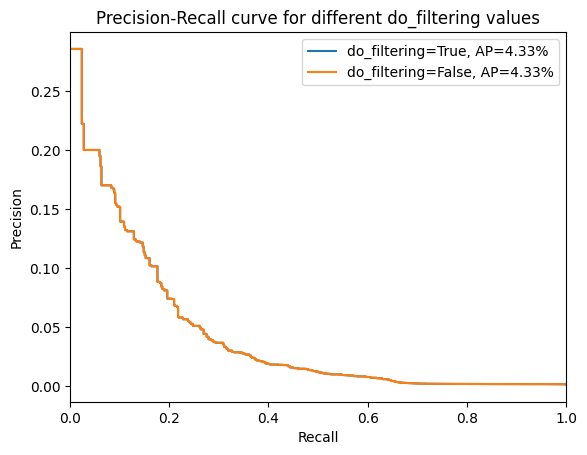

In [189]:

do_filtering_values = detections['do_filtering'].unique()

fig, ax = plt.subplots()

for do_filtering in do_filtering_values:
    test = get_detections_for_params(detections, do_filtering=do_filtering)
    print(len(test), do_filtering)
    print(test.head(5))
    

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"do_filtering={do_filtering}, AP={100 * ap:.2f}%")
    

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values")
plt.show()

49278 True
F1 Working Point:
621186 False
F1 Working Point:


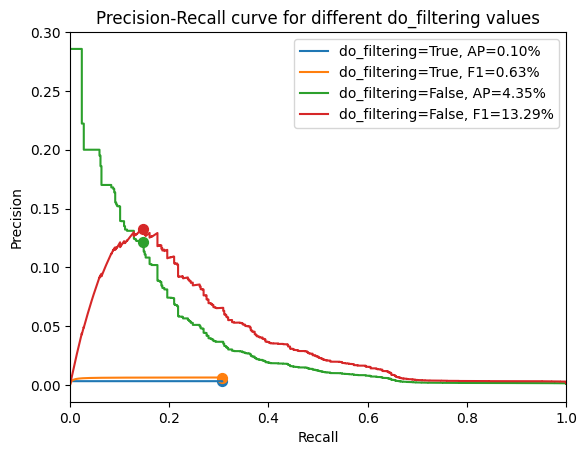

In [170]:

do_filtering_values = detections['do_filtering'].unique()

fig, ax = plt.subplots()

for do_filtering in do_filtering_values:
    test = get_detections_for_params(detections, do_filtering=do_filtering)
    print(len(test), do_filtering)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)
    f1 = bb.stat.fscore(pr)
    threshold = bb.stat.peak(f1)
    print('F1 Working Point:')
    pr_point = bb.stat.point(pr, threshold.confidence)

    ax.plot(pr['recall'], pr['precision'], label=f"do_filtering={do_filtering}, AP={100 * ap:.2f}%")
    plt.scatter(pr_point.recall, pr_point.precision, s=50)
    ax.plot(f1['recall'], f1['f1'], label=f"do_filtering={do_filtering}, F1={100 * f1['f1'].max():.2f}%")
    plt.scatter(threshold.recall, threshold.f1, s=50)
    

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values")
plt.show()

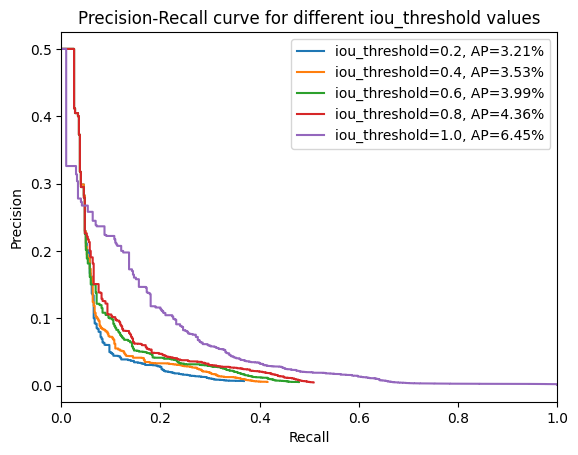

In [163]:

iou_threshold_values = detections['iou_threshold'].unique()
iou_threshold_values.sort()

fig, ax = plt.subplots()

for iou_threshold in iou_threshold_values:
    test = get_detections_for_params(detections, iou_threshold=iou_threshold)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"iou_threshold={iou_threshold}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different iou_threshold values")
plt.show()


35550 True
471744 False


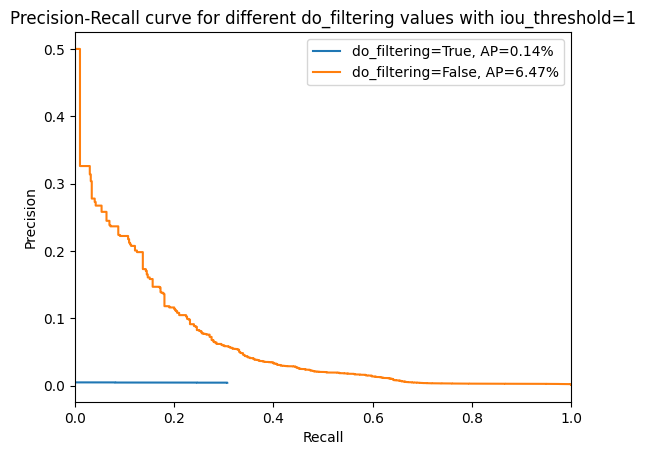

In [164]:

fig, ax = plt.subplots()

for do_filtering in do_filtering_values:
    test = get_detections_for_params(detections, do_filtering=do_filtering, iou_threshold=1)
    print(len(test), do_filtering)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"do_filtering={do_filtering}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values with iou_threshold=1")
plt.show()


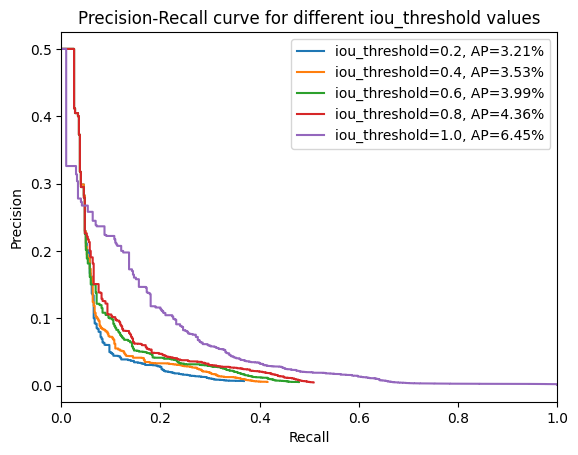

In [165]:

fig, ax = plt.subplots()

for iou_threshold in iou_threshold_values:
    test = get_detections_for_params(detections, iou_threshold=iou_threshold)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"iou_threshold={iou_threshold}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different iou_threshold values")
plt.show()


35550 True
471744 False


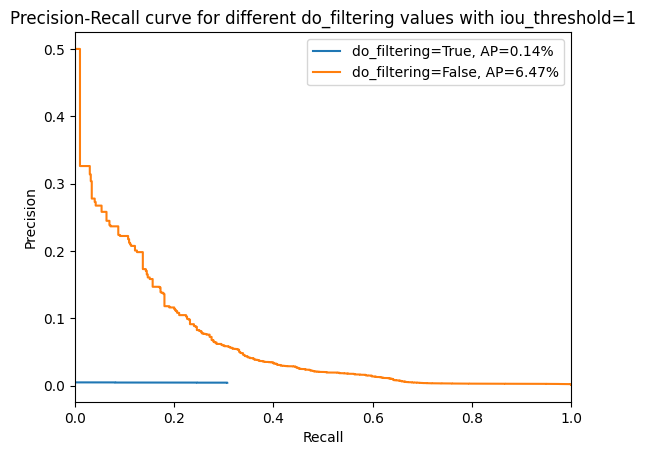

In [166]:

fig, ax = plt.subplots()

for do_filtering in do_filtering_values:
    test = get_detections_for_params(detections, do_filtering=do_filtering, iou_threshold=1)
    print(len(test), do_filtering)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"do_filtering={do_filtering}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different do_filtering values with iou_threshold=1")
plt.show()


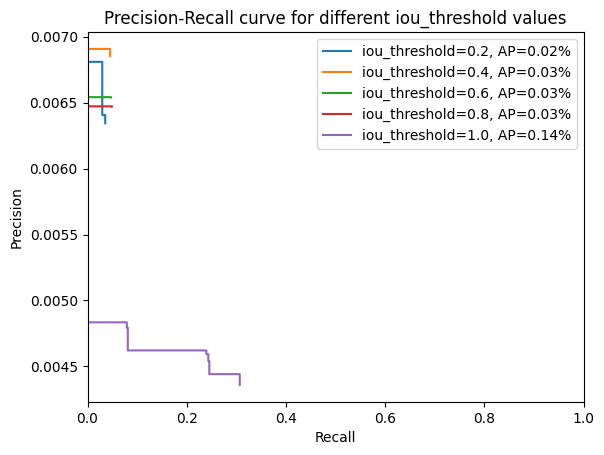

In [167]:

fig, ax = plt.subplots()

for iou_threshold in iou_threshold_values:
    test = get_detections_for_params(detections, iou_threshold=iou_threshold, do_filtering=True)

    pr = bb.stat.pr(test, test_image_annotations, threshold=0., smooth=True)
    ap = bb.stat.ap(pr)

    ax.plot(pr['recall'], pr['precision'], label=f"iou_threshold={iou_threshold}, AP={100 * ap:.2f}%")

ax.set_xlim(0,1)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.title("Precision-Recall curve for different iou_threshold values")
plt.show()

In [145]:
filtered = get_detections_for_params(detections, do_filtering=True)

bb.io.save(filtered, "pandas",f"filtered.csv")

Saving as csv does not retain categorical dtypes! You will thus lose all images that have no boxes.
